In [87]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
import tensorflow as tf

In [88]:
S0 = 1

In [89]:
r = 0.00
sig = 0.2 #변동성
tsig = 0.2
T = 150/365 # 만기까지 남은 일/년

M = 1000 # 시나리오 개수
N = 150 # 시간을 나누는 개수

dt = T/N #시간의 간격-하루
rdt = r*dt# 하루치 이자
sigsdt = sig * np.sqrt(dt) # 하루치 변동성
tsigsdt =tsig *np.sqrt(dt)

AT_1115 = 7.16 #2016~2020 11월 평균온도
AT_1215 = -0.04#2016~2020 12월 평균온도
AT_0115 = -1.5# 2017~2021 1월 평균온도
AT_0214 = 0.88 #2017~2021 2월 평균온도
AT_0315 = 7.64 #2017~2021 3월 평균온도

AT = np.zeros(151)

for x in range(151) :
  AT[x] = 1.49203397293878e-7*x**4 - 4.74853893305008e-5*x**3 + 0.00757958992122678*x**2 - 0.567576260846709*x + 13.7450361379059



In [90]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

np.random.seed(4321)

T = np.empty([M,N+1])
for i in range(M) :
  T[i,] = AT
tv = np.random.normal(r*dt , tsigsdt , [M,N])


In [91]:
for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])
for i in range(M) :
  for j in range(N) :
    T[i,j] = T[i,j] * (1+tv[i,j])
  

In [92]:
T_AT = np.empty([M,N+1])
for i in range(M) :
  T_AT[i,] =AT
T_AT =( T -T_AT) / T


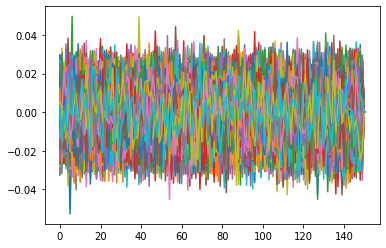

In [93]:
for i in range(M):
    plt.plot(T_AT[i,:])

plt.show()

In [94]:
TS = 0.5*S + 0.5*(S0 * (1+T_AT) )

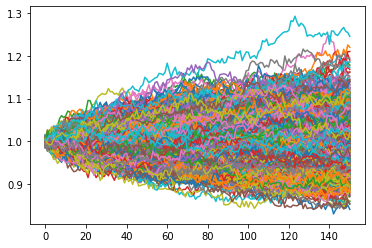

In [95]:
for i in range(M):
    plt.plot(TS[i,:])

plt.show()

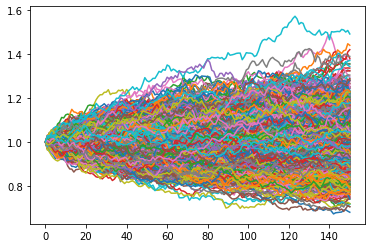

In [96]:
for i in range(M):
    plt.plot(S[i,:])

plt.show()

In [97]:
def HDD(temp) :
  HD = np.max(18-temp,0)
  return HD


In [98]:
HDD_list = []
for i in range(len(AT)) :
  HDD_day = HDD(AT[i])
  HDD_list.append(HDD_day)
HDD_AT = sum(HDD_list)


In [99]:
HDD_T_list =np.zeros([M,N])
for i in range(M) :
  for j in range(N) :
    HDD_day = HDD(T[i,j])
    HDD_T_list[i,j] = HDD_day
HDD_T = []
for i in range(M) :
  HDD_T.append(sum(HDD_T_list[i,]))
K = HDD_AT

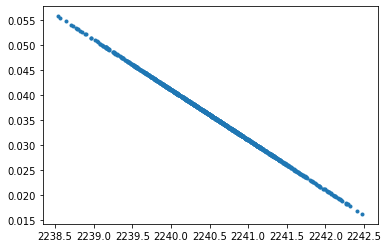

In [100]:
payoff = list(map(lambda x : np.max(K-x,0),HDD_T)) 
def na(x) : # 지수의 1/100 만큼을 페이오프로 설정
  x = x / 100
  return x
payoff = list(map(na,payoff))

plt.plot( HDD_T,payoff,linestyle='none',marker=".")

In [101]:
input_data = []

cost = tf.keras.layers.Input(shape=(1,),name="cost")
price = tf.keras.layers.Input(shape=(1,),name="price")
hdd = tf.keras.layers.Input(shape=(1,),name="hdd")

input_data += [cost]
input_data+=[hdd]
input_data+=[price]

for i in range(N) :
  delta = tf.keras.layers.Dense(24,activation='leaky_relu')(price)
  delta = tf.keras.layers.Dense(16,activation='leaky_relu')(delta)
  delta = tf.keras.layers.BatchNormalization()(delta)
  delta = tf.keras.layers.Dense(8,activation='tanh')(delta)
  delta = tf.keras.layers.Dense(4,activation='elu')(delta)
  delta = tf.keras.layers.Dense(1)(delta)

  new_price = tf.keras.layers.Input(shape=(1,),name="new_price"+str(i))
  input_data = input_data +  [new_price]
  price_inc = tf.keras.layers.Subtract(name="price_inc"+str(i))([price,new_price])
  del_mul_pi = tf.keras.layers.Multiply(name="del_mul_pi"+str(i))([delta,price_inc])
  cost = tf.keras.layers.Add(name="cost"+str(i))([del_mul_pi,cost])
  price =new_price


HDD_payoff = tf.keras.layers.Lambda(lambda x : tf.maximum(K-x,0)/100)(hdd)
result = tf.keras.layers.Subtract(name="result")([HDD_payoff,cost])

model = tf.keras.Model(inputs=input_data,outputs=result)


In [102]:
C = np.zeros([M,1])
H = np.array(HDD_T).reshape(M,1)
P_NP = [S[:,i].reshape(M,1) for i in range(N+1)]

x = [C]+[H]+[P_NP]
y = np.array(payoff)



In [103]:

model.compile(optimizer='adam',loss='mse')

In [104]:
model.fit(x,y, batch_size=128, epochs=100,  verbose=True)

Epoch 1/100
8/8 [==============================] - 70s 83ms/step - loss: 0.0017
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 6.3252e-04
Epoch 3/100
8/8 [==============================] - 1s 83ms/step - loss: 2.6411e-04
Epoch 4/100
8/8 [==============================] - 1s 84ms/step - loss: 1.3988e-04
Epoch 5/100
8/8 [==============================] - 1s 82ms/step - loss: 7.7173e-05
Epoch 6/100
8/8 [==============================] - 1s 85ms/step - loss: 4.6658e-05
Epoch 7/100
8/8 [==============================] - 1s 85ms/step - loss: 2.9397e-05
Epoch 8/100
8/8 [==============================] - 1s 84ms/step - loss: 2.1350e-05
Epoch 9/100
8/8 [==============================] - 1s 84ms/step - loss: 1.5991e-05
Epoch 10/100
8/8 [==============================] - 1s 84ms/step - loss: 1.3029e-05
Epoch 11/100
8/8 [==============================] - 1s 86ms/step - loss: 1.1375e-05
Epoch 12/100
8/8 [==============================] - 1s 84ms/step - loss: 9.4341e-06
Epoc

In [105]:

model.predict(x)

array([[ 0.03929658],
       [ 0.03421394],
       [ 0.04630601],
       [ 0.02123886],
       [ 0.03328292],
       [ 0.04934487],
       [ 0.06905373],
       [ 0.02269231],
       [ 0.02442054],
       [ 0.03908293],
       [ 0.02943079],
       [ 0.05355929],
       [ 0.03642859],
       [ 0.04096948],
       [ 0.04076664],
       [ 0.03402311],
       [ 0.00142141],
       [ 0.0574715 ],
       [ 0.04019439],
       [ 0.02784541],
       [ 0.04103209],
       [ 0.02477998],
       [ 0.02698353],
       [ 0.03568971],
       [ 0.04171542],
       [ 0.02895584],
       [ 0.03487458],
       [ 0.03001098],
       [ 0.0361068 ],
       [ 0.04005567],
       [ 0.03149074],
       [ 0.01797568],
       [ 0.03208043],
       [ 0.0321519 ],
       [ 0.04551011],
       [ 0.02784095],
       [ 0.03276407],
       [ 0.04605758],
       [ 0.06595833],
       [ 0.03410922],
       [ 0.03341991],
       [ 0.03718296],
       [ 0.04052275],
       [ 0.0346295 ],
       [ 0.02684742],
       [ 0

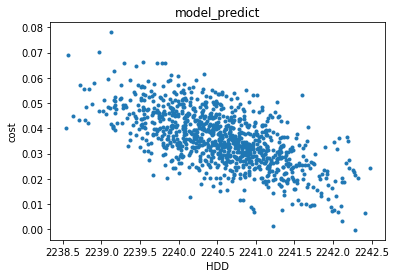

In [107]:
plt.plot( HDD_T,model.predict(x),linestyle='none',marker=".")
plt.xlabel('HDD')
plt.ylabel('cost')
plt.title("model_predict")
plt.show()

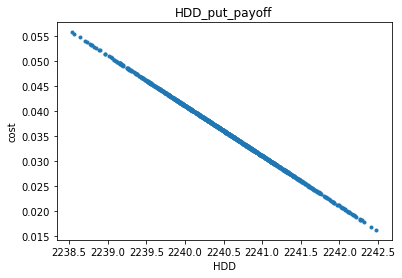

In [108]:
plt.plot(HDD_T,payoff,linestyle='none',marker='.')
plt.xlabel('HDD')
plt.ylabel('cost')
plt.title("HDD_put_payoff")
plt.show()